## "Now Playing" soft sim/genre demo
##### John Kirchenbauer, 08/08/20
#### Insight AI interview project
- audio processing and manipulation - be ready with small FMA data
- ** possible beat detection - Likelynot
- CNN AutoEncoder - initially a compression
    - tuning for layers, then tune input shape/channels
- Knn etc. for sim and top-k classification
- ** possible split into federated setup


In [1]:
from os import path
import pandas as pd
import numpy as np
import scipy as sp
# import tensorflow as tf
# from tensorflow import keras as K
import sklearn as sk
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm

import warnings # this is only for the librosa mp3 decoding lib warning
warnings.filterwarnings('ignore')
import librosa
import librosa.display

In [2]:
import utils

### Data Load, Feature Transform

In [3]:
# filename = 'DATA/test/02_invincible.mp3'
# filename = 'DATA/000/000140.mp3'
# filename = 'DATA/000/000010.mp3'
# filename = 'DATA/000/000210.mp3'
# filename = 'DATA/000/000822.mp3'
# filename = 'DATA/000/000211.mp3'
# filename = 'DATA/000/000256.mp3'
# filename = 'DATA/000/000424.mp3'
filename = 'DATA/000/000708.mp3'

# ipd.Audio(filename)

In [4]:
x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

Duration: 29.99s, 1322496 samples


In [5]:
start, end = 15, 18
x = x[start*sr:end*sr]
ipd.Audio(data=x, rate=sr)

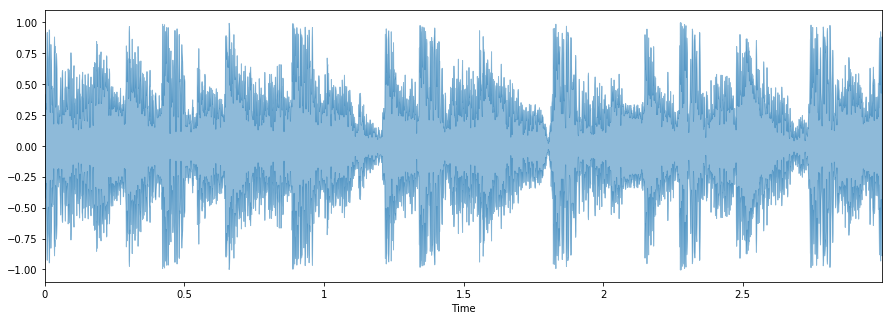

In [6]:
plt.figure(figsize=(15,5))
librosa.display.waveplot(x, sr, alpha=0.5);
plt.vlines([start, end], -1, 1)

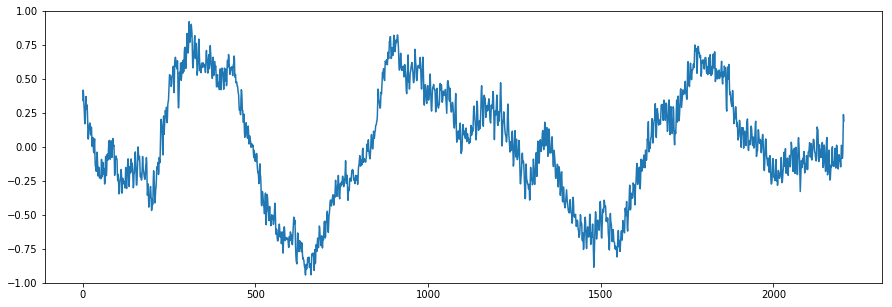

In [7]:
# start = len(x) // 2
# plt.plot(x[start:start+2000])
plt.figure(figsize=(15,5))
plt.plot(x[:int(sr*0.05)])
plt.ylim((-1, 1));

In [8]:
# x = x[25*sr:28*sr]

In [9]:
# # n_fft, hop_length = 2048, 512
# # tuned for a 128x128 given the duration
# n_fft, hop_length = 1024,1034 # 3 sec
# # n_fft, hop_length = 1024,346 # 1 sec

# stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))

# mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
# log_mel = librosa.amplitude_to_db(mel)
# plt.figure(figsize=(10,5))
# librosa.display.specshow(log_mel, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');

In [10]:
# mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
# mfcc = sk.preprocessing.StandardScaler().fit_transform(mfcc)
# plt.figure(figsize=(15,5))
# librosa.display.specshow(mfcc, sr=sr, x_axis='time');

In [11]:
# mfcc.shape
# # np.shape(np.mean(mfcc.T,axis=0))
# # stft.shape
# log_mel.shape
# # mel.shape
# # stft[0][:]

In [77]:
def melspec_encode_mp3(filename, duration_sec = 3, start_sec = 15, n_fft = 1024, hop_length = 1034,n_mels=128, verbose = False, disp = False):
    
    # forcing smaple rate to ensure encoding dims
    x, sr = librosa.load(filename, sr=44100, mono=True)
    if verbose: print('Filename: {}, Duration: {:.2f}s, {} samples, sample rate {}hz '.format(filename, x.shape[-1] / sr, x.size, sr))

        
    end = start + duration_sec
    x = x[start*sr:end*sr]
    
    # n_fft, hop_length = 1024,346 # 1 sec, default is for 3
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=n_mels)
    log_mel = librosa.amplitude_to_db(mel)
    if verbose: print('Encoded shape: {}'.format(log_mel.shape))
        
#     log_mel = sk.preprocessing.StandardScaler().fit_transform(log_mel)
    
    if disp: plt.figure(figsize=(10,5))
    if disp: librosa.display.specshow(log_mel, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    
    return log_mel, x, sr
    

## Testing encoding steps

In [346]:
# filename = 'DATA/000/000676.mp3'
# filename = 'DATA/000/000625.mp3'
# filename = 'DATA/000/000140.mp3'

# filename = 'DATA/017/017631.mp3'
# filename = 'DATA/001/001663.mp3'
# filename = 'DATA/000/000667.mp3'

# filename = 'DATA/003/003908.mp3'
# filename = 'DATA/004/004684.mp3'
# filename = 'DATA/008/008416.mp3'
# filename = 'DATA/022/022315.mp3'
# filename = 'DATA/010/010682.mp3'

In [347]:
# Neighbors of  004232.mp3 International
# are  ['003492.mp3' '007709.mp3' '004066.mp3' '001075.mp3']

# Neighbors of  003908.mp3 Folk
# are  ['004684.mp3' '008416.mp3' '022315.mp3' '010682.mp3']
# are  ['Hip-Hop' 'Experimental' 'International' 'Folk']

Filename: DATA/008/008416.mp3, Duration: 29.99s, 1322496 samples, sample rate 44100hz 
Encoded shape: (128, 128)


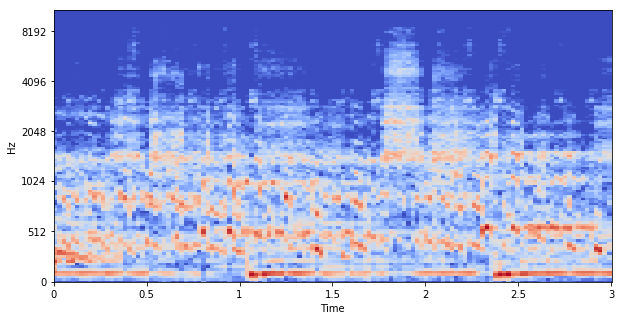

In [348]:
# mel_spec_enc, raw, sr = melspec_encode_mp3(filename, duration_sec = 3,n_fft = 2048, hop_length = 518, n_mels=128, verbose=True,disp=True)
# mel_spec_enc,raw, sr = melspec_encode_mp3(filename, duration_sec = 3, n_fft = 2048, hop_length = 1034, verbose=True,disp=True)
mel_spec_enc,raw, sr = melspec_encode_mp3(filename, duration_sec = 3, n_fft = 2048, hop_length = 1034,n_mels=128, verbose=True,disp=True)

In [349]:
ipd.Audio(data=raw, rate=sr)

In [350]:
# audio_signal = librosa.feature.inverse.mel_to_audio(
#         mel_spec_enc, sr=sr, n_fft = 2048, hop_length = 518, window=sp.signal.hanning)
audio_signal = librosa.feature.inverse.mel_to_audio(
        mel_spec_enc, sr=sr, n_fft = 2048, hop_length = 1034, window=sp.signal.hanning)

ipd.Audio(data=audio_signal, rate=sr)

In [256]:
# np.save('DATA/out/test.npy', raw)

In [83]:
# reloaded = np.load('DATA/out/test.npy')
# ipd.Audio(data=reloaded, rate=sr)

## Multifile encoding from meta

In [84]:
tracks = utils.load('DATA/fma_metadata/tracks.csv')
meta = tracks[tracks['set', 'subset'] <= 'small']

In [85]:
print(meta['track'].columns)
# print(meta['album'].columns)
# meta['artist'].columns

Index(['bit_rate', 'comments', 'composer', 'date_created', 'date_recorded',
       'duration', 'favorites', 'genre_top', 'genres', 'genres_all',
       'information', 'interest', 'language_code', 'license', 'listens',
       'lyricist', 'number', 'publisher', 'tags', 'title'],
      dtype='object')


In [86]:
sub_meta = meta.filter([('track', 'title'),('album', 'title'),('track', 'genre_top'),('track', 'genres'),('track', 'genres_all'), ('album', 'date_released'),('album', 'producer'),('artist', 'name')])
sub_meta.head()

track                  album     track         \
                       title                  title genre_top genres   
track_id                                                               
2                       Food   AWOL - A Way Of Life   Hip-Hop   [21]   
5                 This World   AWOL - A Way Of Life   Hip-Hop   [21]   
10                   Freeway      Constant Hitmaker       Pop   [10]   
140       Queen Of The Wires         The Blind Spot      Folk   [17]   
141                     Ohio  Every Man For Himself      Folk   [17]   

                            album                                  \
         genres_all date_released                        producer   
track_id                                                            
2              [21]    2009-01-05                             NaN   
5              [21]    2009-01-05                             NaN   
10             [10]    2008-02-06                             NaN   
140            [17]    2007-05-22  Alec K. Refearn, Rob Pemberton   
141            [17]    2009-01-16                             NaN   

                                   artist  
                                     name  
track_id                                   
2                                    AWOL  
5                                    AWOL  
10                              Kurt Vile  
140       Alec K. Redfearn & the Eyesores  
141       Alec K. Redfearn & the Eyesores

In [87]:
sub_meta.columns = sub_meta.columns.droplevel(0)
sub_meta.rename(columns={ sub_meta.columns[0]: "track_title", sub_meta.columns[1]: "album_title" }, inplace = True)

In [88]:
sub_meta.head()

,album_title,album_title,genre_top,genres,genres_all,date_released,producer,name
track_id,,,,,,,,
2,Food,AWOL - A Way Of Life,Hip-Hop,[21],[21],2009-01-05,NaN,AWOL
5,This World,AWOL - A Way Of Life,Hip-Hop,[21],[21],2009-01-05,NaN,AWOL
10,Freeway,Constant Hitmaker,Pop,[10],[10],2008-02-06,NaN,Kurt Vile
140,Queen Of The Wires,The Blind Spot,Folk,[17],[17],2007-05-22,"Alec K. Refearn, Rob Pemberton",Alec K. Redfearn & the Eyesores
141,Ohio,Every Man For Himself,Folk,[17],[17],2009-01-16,NaN,Alec K. Redfearn & the Eyesores


In [89]:
def load_files(meta_df, base_path = 'DATA/'):
    filenames, encodings, raw_audio, sr_list, genres = [],[],[],[],[]
#     print("files to encode: ",len(meta_df))
#     np.zeros((len(meta_df)))
    for index,row in tqdm(meta_df.iterrows()):
        filename = str(index).rjust(6, '0')+'.mp3'
        DIR = filename[:3]+'/'
        mel_spec_enc, raw, sr = melspec_encode_mp3(base_path+DIR+filename,duration_sec = 3, n_fft = 2048, hop_length = 1034, n_mels=128, verbose=False,disp=False)
        filenames.append(filename)
#         if mel_spec_enc.shape[0] > 128: print("First dim too big")
#         if mel_spec_enc.shape[1] > 128: print("Second dim too big")
        encodings.append(mel_spec_enc[:,:128])
        raw_audio.append(raw)
        sr_list.append(sr)
        genres.append(row['genre_top'])

    return (filenames, encodings, raw_audio, sr_list, genres)

In [90]:
sub_set = sub_meta.loc[:60000]
print(len(sub_set))
names,encodings,raw_audio,sr_list, genres = load_files(sub_set)
# names,encodings,raw_audio,sr_list, genres = load_files(sub_meta)

0it [00:00, ?it/s]

2584


2584it [08:57,  2.08it/s]


In [91]:
enc_dim = encodings[0].shape
print(enc_dim)

(128, 128)


In [92]:
# new_encs = np.concatenate( encodings, axis=0 )
# new_encs.shape
# for arr,name in zip(encodings,names): 
#     if arr.shape != (128,128):
#         print(name)
#         print(arr.shape) 

In [93]:
print(len(names))
names[3]

2584


'000140.mp3'

In [94]:
encodings[0][0][100:102]

array([-11.594574, -11.594574], dtype=float32)

In [95]:
# print(np.max(encodings))
normed_encodings = encodings/np.max(encodings)

normed_encodings[0][0][100:102]

array([-0.14191213, -0.14191213], dtype=float32)

In [96]:
# for name, enc in zip(names,encodings):
#     np.save('DATA/encoded_tracks/small_000_128x256/'+name.replace('.mp3','.npy'), enc)

In [97]:
# names[:10]

In [98]:
# load test
# reloaded = np.load('DATA/encoded_tracks/small_000_128x256/000676.npy')

# reloaded = encodings[3]
# reloaded = normed_encodings[3]


# audio_signal = librosa.feature.inverse.mel_to_audio(
#         reloaded, sr=sr_list[0], n_fft = 2048, hop_length = 1034, window=sp.signal.hanning)
# audio_signal = raw_audio[3]

In [99]:
# print(names[3])

In [100]:
# ipd.Audio(data=audio_signal, rate=sr_list[0])

In [101]:
# plt.figure(figsize=(10,5))
# librosa.display.specshow(reloaded, sr=sr_list[0], hop_length = 1034, x_axis='time', y_axis='mel')

### CNN Instantiation

In [102]:
import tensorflow as tf
from tensorflow import keras as K
tf.config.experimental_run_functions_eagerly(True)


In [103]:
# n_hidden_1, n_hidden_2, n_hidden_3 = 64, 32, 16
n_hidden_1, n_hidden_2, n_hidden_3 = 128, 256, 512

convkernel = 3  # convolution kernel
stride = 2
# input_shape=(128, 256, 1)
input_shape=(128, 128, 1)


K.backend.clear_session()

input_layer = K.layers.Input(shape=input_shape)
x = K.layers.Conv2D(n_hidden_1, convkernel, strides = stride, activation='relu', padding='same')(input_layer)
x = K.layers.Conv2D(n_hidden_2, convkernel, strides = stride, activation='relu', padding='same')(x)
x = K.layers.Conv2D(n_hidden_3, convkernel, strides = stride, activation='relu', padding='same')(x)
x = K.layers.Flatten()(x)
encoded = K.layers.Dense(16, activation="relu")(x)

encoder = K.Model(input_layer, encoded, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 512)       1180160   
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                2097168   
Total params: 3,573,776
Trainable params: 3,573,776
Non-trainable params: 0
_________________________________________________

In [104]:
encoder_output_shape = encoder.layers[-1].output_shape[1:]
print(encoder_output_shape)

(16,)


In [105]:
# latent_inputs = K.layers.Input(shape=encoder_output_shape)
# x = K.layers.Dense(16 * 32 * 16, activation="relu")(latent_inputs)

# x = K.layers.Dense(16 * 32 * 16, activation="relu")(encoded)
# x = K.layers.Reshape((16, 32, 16))(x)

latent_inputs = K.layers.Input(shape=encoder_output_shape)
x = K.layers.Dense(16 * 16 * 512, activation="relu")(latent_inputs)
x = K.layers.Reshape((16, 16, 512))(x)
x = K.layers.Conv2DTranspose(n_hidden_3, convkernel, activation="relu", strides=2, padding="same")(x)
x = K.layers.Conv2DTranspose(n_hidden_2, convkernel, activation="relu", strides=2, padding="same")(x)
x = K.layers.Conv2DTranspose(n_hidden_1, convkernel, activation="relu", strides=2, padding="same")(x)

# decoder_outputs = K.layers.Conv2DTranspose(1, convkernel, activation="sigmoid", padding="same")(x)
decoder_outputs = K.layers.Conv2DTranspose(1, convkernel, activation="tanh", padding="same")(x)

decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            2228224   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 512)       2359808   
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       1179904   
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 128)     295040    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 1)       1153

In [106]:
ae_input_layer = K.layers.Input(shape=input_shape)
encoded = encoder(ae_input_layer)
decoded = decoder(encoded)
ae = K.Model(ae_input_layer, decoded)
ae.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
encoder (Model)              (None, 16)                3573776   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       6064129   
Total params: 9,637,905
Trainable params: 9,637,905
Non-trainable params: 0
_________________________________________________________________


In [107]:
# ae.compile(optimizer=K.optimizers.Adam(), loss='binary_crossentropy')
ae.compile(optimizer=K.optimizers.Adam(), loss='mean_squared_error')
# ae.compile(optimizer=K.optimizers.Adam(), loss='mean_absolute_error')

In [108]:
# ae_checkpoint_filepath = 'MODEL/ae_checkpoint'
# model_checkpoint_callback = K.callbacks.ModelCheckpoint(
#     filepath=ae_checkpoint_filepath,
#     monitor='loss',
#     mode='min',
#     save_best_only=True)

In [109]:
# len(encodings[0])

# train_array = np.array(encodings)
train_array = np.array(normed_encodings)

train_array.shape

(2584, 128, 128)

In [110]:
# train_array = np.reshape(train_array,(-1, 128, 256, 1))
train_array = np.reshape(train_array,(-1, 128, 128, 1))
train_array.shape

(2584, 128, 128, 1)

In [ ]:
# LOAD MODEL
# ae = K.models.load_model("MODEL/saved_model")

In [208]:
# TRAINING BLOCK
ae.fit(train_array, train_array, epochs=40, batch_size = 128)
# ae.fit(train_array, train_array, epochs=2, batch_size = 32)
# ae.fit(train_array, train_array, epochs=2, batch_size = 128, callbacks=[model_checkpoint_callback])

Train on 2584 samples
Epoch 1/40
2584/2584 [==============================] - 684s 265ms/sample - loss: 0.0636
Epoch 2/40
2584/2584 [==============================] - 676s 262ms/sample - loss: 0.0318
Epoch 3/40
2584/2584 [==============================] - 655s 254ms/sample - loss: 0.0253
Epoch 4/40
 896/2584 [=========>....................] - ETA: 6:33 - loss: 0.0240

KeyboardInterrupt: 

In [ ]:
# SAVE MODEL
# ae.save("MODEL/saved_model")

### AE testing, orig vs reconstructed

In [232]:
# ind = 34
# ind = 230
# ind = 3
# ind = 125
ind = 407

orig = train_array[ind:ind+1]
reconstructed = ae.predict(train_array[ind:ind+1])

# orig = np.reshape(orig, (128,256,))
# reconstructed = np.reshape(reconstructed, (128,256,))
orig = np.reshape(orig, (128,128,))
reconstructed = np.reshape(reconstructed, (128,128,))

In [233]:

# print(sr_list[0])
print(names[ind:ind+1])

['009918.mp3']


In [234]:
# audio_signal = librosa.feature.inverse.mel_to_audio(
#         orig, sr=sr_list[0], n_fft = 2048, hop_length = 518, window=sp.signal.hanning)
audio_signal = librosa.feature.inverse.mel_to_audio(
        orig, sr=sr_list[0], n_fft = 2048, hop_length = 1034, window=sp.signal.hanning)


ipd.Audio(data=audio_signal, rate=sr_list[0])

In [235]:
# audio_signal = librosa.feature.inverse.mel_to_audio(
#         reconstructed, sr=sr_list[0], n_fft = 2048, hop_length = 512, window=sp.signal.hanning)
audio_signal = librosa.feature.inverse.mel_to_audio(
        reconstructed, sr=sr_list[0], n_fft = 2048, hop_length = 1034, window=sp.signal.hanning)

ipd.Audio(data=audio_signal, rate=sr_list[0])

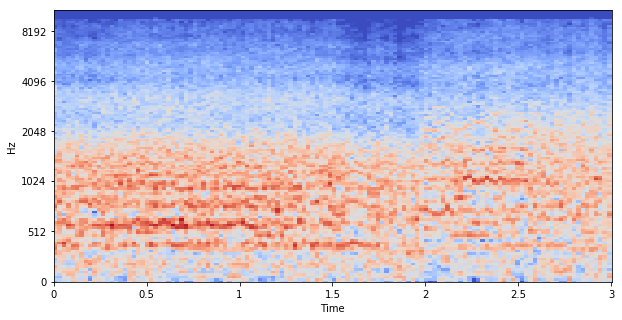

In [236]:
plt.figure(figsize=(10,5))
# librosa.display.specshow(orig, sr=sr_list[0], hop_length = 518, x_axis='time', y_axis='mel')
librosa.display.specshow(orig, sr=sr_list[0], hop_length = 1034, x_axis='time', y_axis='mel')

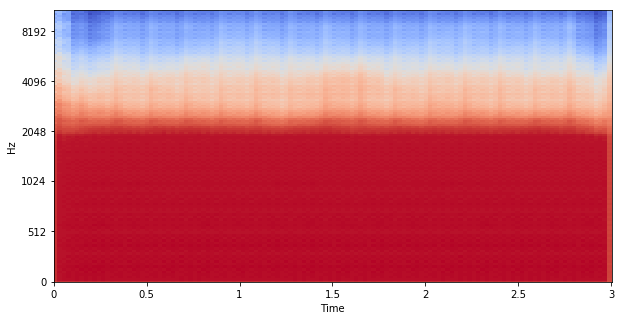

In [237]:
plt.figure(figsize=(10,5))
# librosa.display.specshow(reconstructed, sr=sr_list[0], hop_length = 518, x_axis='time', y_axis='mel')
librosa.display.specshow(reconstructed, sr=sr_list[0], hop_length = 1034, x_axis='time', y_axis='mel')

### Encoder testing 

In [261]:
ind = 34
batch_len = 1000

orig = train_array[ind:ind+batch_len]
encoded = encoder.predict(train_array[ind:ind+batch_len])

name_list = np.array(names[ind:ind+batch_len])
genre_list = np.array(genres[ind:ind+batch_len])

In [262]:
print(name_list[:10])
print(genre_list[:10])

['000667.mp3' '000676.mp3' '000690.mp3' '000694.mp3' '000695.mp3'
 '000704.mp3' '000705.mp3' '000706.mp3' '000707.mp3' '000708.mp3']
['International' 'Hip-Hop' 'Rock' 'Hip-Hop' 'Hip-Hop' 'International'
 'International' 'International' 'International' 'International']


In [263]:
print(encoded[:10])

[[0.         0.         0.         6.3151507  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         4.48446    0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.3104106  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         4.9052615  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         2.4854321  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.1290634  0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        

### Populate KNN and similarity search

In [248]:
from sklearn.neighbors import NearestNeighbors

In [264]:
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(encoded)
distances, indices = nbrs.kneighbors(encoded)

In [265]:
indices

array([[  0, 895, 402, 888, 669],
       [  1, 654, 468, 490, 671],
       [  2, 682, 625, 515, 884],
       ...,
       [997, 995, 998, 994, 996],
       [998, 997, 995, 994, 996],
       [999, 494, 398, 326, 343]])

In [266]:
for i,neighbor_indices in enumerate(indices):
    print("Neighbors of ",name_list[i], genre_list[i])
    print("are ",name_list[neighbor_indices[1:]])
    print("are ",genre_list[neighbor_indices[1:]])

Neighbors of  000667.mp3 International
are  ['022348.mp3' '010481.mp3' '022094.mp3' '014583.mp3']
are  ['Pop' 'Folk' 'Hip-Hop' 'Instrumental']
Neighbors of  000676.mp3 Hip-Hop
are  ['014538.mp3' '011672.mp3' '011776.mp3' '014585.mp3']
are  ['Hip-Hop' 'International' 'Hip-Hop' 'Instrumental']
Neighbors of  000690.mp3 Rock
are  ['014663.mp3' '013708.mp3' '011867.mp3' '022001.mp3']
are  ['Pop' 'Electronic' 'Hip-Hop' 'Pop']
Neighbors of  000694.mp3 Hip-Hop
are  ['024362.mp3' '022480.mp3' '001196.mp3' '012059.mp3']
are  ['International' 'Pop' 'Folk' 'Folk']
Neighbors of  000695.mp3 Hip-Hop
are  ['001925.mp3' '013748.mp3' '004786.mp3' '011861.mp3']
are  ['Folk' 'Hip-Hop' 'Rock' 'Hip-Hop']
Neighbors of  000704.mp3 International
are  ['011916.mp3' '002099.mp3' '000707.mp3' '021891.mp3']
are  ['Hip-Hop' 'Pop' 'International' 'Electronic']
Neighbors of  000705.mp3 International
are  ['021895.mp3' '000708.mp3' '011919.mp3' '021085.mp3']
are  ['Electronic' 'International' 'Hip-Hop' 'Electronic']
N